**Hybrid Recommendation Algorithm using MovieLens 100k Dataset:**

*Basic information:*
- Dataset used: Movielens 100k data
- Type of recomendation model: Combination of SVD + Content-based filtering

*Why this approach?*

- Using a weighted hybrid system combining Content-filtering and Matrix Factorization Techniques to build off the limitations of both algorithms, to provide more accurate recommendations to the user
- Strengths of SVD: 
    - Good at understanding user-item iteraction relationships 
    - Offers the component of user-personalization
    
- Strengths of Content-based: 
    - Does not rely on user-item iteractions
    - Recommends movies based upon move metadata (e.g. genres)
    - Can avoid popularity bias
    
- Using both:
    - Allows for the system to recommend movies based on both the user-item relationships as well as the metadata of the movies
    - Mix of user personalization + exact metadata preferences 


Throughout this code, I used various libraries, starting off with pandas, numpy, as well as sklearn.model_selection (to split 80%-20% training, testing data).

I also uploaded each individual csv file of the MovieLens dataset into its own dataframe.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
links_df = pd.read_csv("MovieData/links.csv")
movies_df = pd.read_csv("MovieData/movies.csv")
ratings_df = pd.read_csv("MovieData/ratings.csv")
tags_df = pd.read_csv("MovieData/tags.csv")

In [3]:
train_datas, test_datas = train_test_split(ratings_df,  
                          random_state=104, 
                          train_size=0.8, shuffle=True) 

#train_datas represents the 80% split of the ratings.csv file (ratings_df) into the training data
#test_datas represents the 20% split of the ratings.csv file (ratings_df) into the testing data

As can be seen above with the distrbution of genres bar chart, genres such as drama, comedy, and action are common in the datasets, meaning these genres are more popular in the users. Because these three genres are common in both the training and testing datasets, it can be predicted that these genres are well represented. Hence, a content-based approach fits this because these genres fit the base for generating more accurate predictions. Similar movies within these genres can be recommended because there is a decent amount of data with them. It will perform well for users who rated similar movies. 
 

The first step is creating the content-based filtering system to predict user ratings in the testing dataset. 

**In the below cell, here is what I did.**

- First of all, as can be seen in the movies_df (which is movies.csv file), some movies have a year name within the title. Example is Toy Story (1995). I cleaned the title data by putting the year in a separate column of its own in the movies_df dataframe, labeled "year". 
- In order to extract the paranthesis covering the year name, in the form (4 digit year), I used a regex expression: r'\((\d{4})\)'. What this does is extract the opening and closing parenthesis as well as four digits within it. The extraction is done using str.extract on movies_df['title']. I take the content that was extracted, and place it into a new column created within the movies_df dataframe, "year". 

- After that, I create two new dataframe on which I will be experimenting the content-based filtering approach with. First I create a dataframe called "content_traindf", which takes the training data which was split earlier and the movies_df (on which we just operated) and merges them together on their common entity, "movieId". The training data is what we will be using to find patterns and experiment different approaches to predict the ratings in the testing data. 

- I do the same process for the testing data (which we split earlier in the 80%-20% method). content_testdf is created by merging the test data and the movies_df. This is the dataframe that will be used to calculate predictions for user ratings using content_traindf. 

In [4]:
#Content-based recommendation system
#Clean the title data to put the year in a separate column of its own in the dataframe, so that it doesn't interfere with the algorithm
from sklearn.feature_extraction.text import CountVectorizer

movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')
movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()

content_traindf = pd.merge(train_datas,movies_df, on='movieId', how='left')

content_testdf = pd.merge(test_datas,movies_df, on='movieId', how='left')


**These are some graphs that support the claims and solution algorithms that I chose to approach this recommendation system**

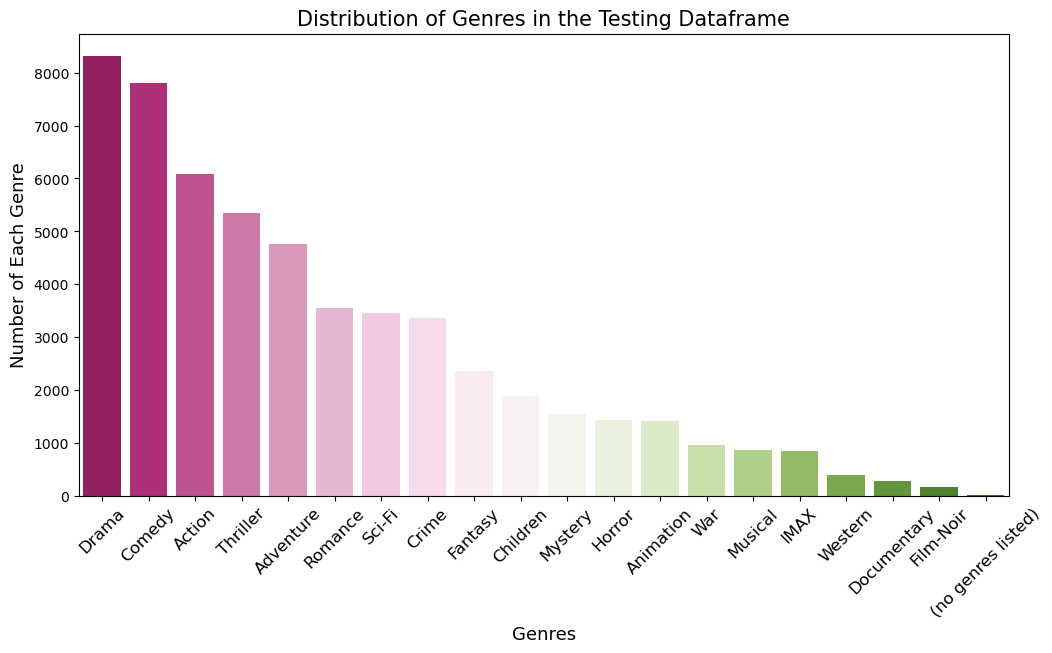

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
genreSplitByBarCount = content_testdf['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genreSplitByBarCount.index, y=genreSplitByBarCount.values, palette="PiYG")
plt.title('Distribution of Genres in the Testing Dataframe', fontsize=15)
plt.xlabel('Genres', fontsize=13)
plt.ylabel('Number of Each Genre', fontsize=13)
plt.xticks(rotation=45, fontsize=12)
plt.show()

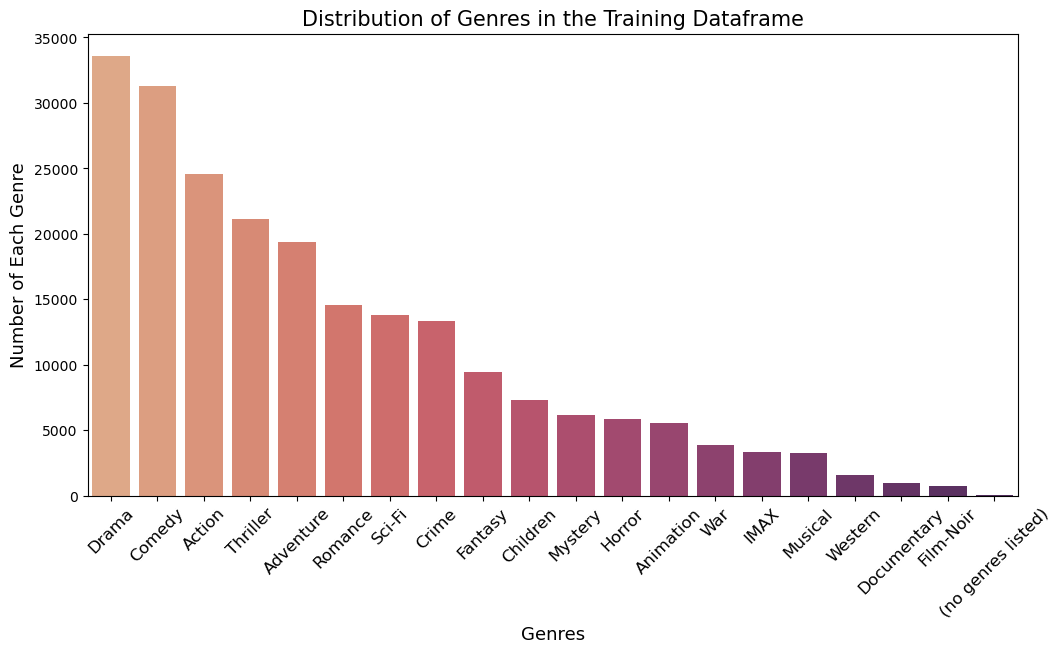

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
genreSplitByBarCount = content_traindf['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=genreSplitByBarCount.index, y=genreSplitByBarCount.values, palette="flare")
plt.title('Distribution of Genres in the Training Dataframe', fontsize=15)
plt.xlabel('Genres', fontsize=13)
plt.ylabel('Number of Each Genre', fontsize=13)
plt.xticks(rotation=45, fontsize=12)
plt.show()

**The first step to creating the content-based recommendation system is to create a user profile using chosen metadata given in the dataset.**

In my approach, I utilized genres along with userid and movieid to make predictions. The purpose of creating user profiles is to understand the user's genre preferences. This is an ideal part of content-based recommendation systems because it also allows to account for movies that have not yet been rated. I can still account for the type of genres that the user likes. Each user's genre preferences are accounted for based on the movies they have watched with the user profiles. 

Here, I defined the function called buildUserProfiles to do this. 

Looking at the "genres" column in the movies.csv file (movies_df dataframe), the genres are split by a |. E.g. Jumanji (1995) has the genres Adventure|Children|Fantasy. To operate on the genres, we will need to get rid of this | that is dividing the genre words. I use a conditional to check if the string (individual rows in the genres column) has a vertical bar in it, it gets split into individual genres. To avoid any overwriting, I create a copy of the string (input_dataframe = input_dataframe.copy()). 

Step by step going through the iterations in the code:

- First, I use a for loop to iterate through each unique user id in the inputted dataframe. 
- Then, I use userMovs to store the number of movies that have been rated by the user by filtering through the input_dataframe.
- I create variables called userGenreRatings (to store the rating for all the genres that were rated by the user) and userNumGenreRatings (to store the number of times that the user rated the individual genres). I use a default dict because it is more effective with datasets that may have missing values. 
- To create the profile, I iterate through the ratings given by the user to calculate statistics about the ratings, the mean rating, min rating, max rating, and the standard deviation. As long as the user rated at least once, the statistics are calculated. If the user has rated no movies, the default value for all the stats is 3.0. 
- I iterate through the rows userMovs dataframe (which contains the movies that user rated), and within this for loop, I iterate through the genres in the genres column of this dataframe. Within this nested for loop, I update the userGenreRatings with the rating given (userGenreRatings[genre] which is the ratings of each individual genre) and increment userNumGenreRatings (userNumGenreRatings[genre]) to account for the number of times that specific genre has been rated. 
- Afterwards, I iterate through the genres in userGenreRatings to calculate the average rating for each genre. The total number of ratings given for each genre is added together and divided by the number of movies the user rated within that genre. 
- Lastly I put together all these calculated statistics for each unique user id to create a dictionary that contains the useful information about the user profile. This is specifically the average ratings for each genre given by the user, the min and max rating, average for all movies rated (without considering genre), and the ratings standard deviation. 
- This dictionary is what the function returns.

In [7]:
from collections import defaultdict
def buildUserProfiles(input_dataframe):
    user_profiles = {}
    if isinstance(input_dataframe['genres'].iloc[0], str): 
        input_dataframe = input_dataframe.copy()
        input_dataframe['genres'] = input_dataframe['genres'].str.split('|')
    for userid in input_dataframe['userId'].unique():
        userMovs = input_dataframe[input_dataframe['userId'] == userid]
        userGenreRatings = defaultdict(float)
        userNumGenreRatings = defaultdict(int)
        userRatingsGiven = userMovs['rating'].values
        if len(userRatingsGiven) > 0:
            uMinimum = np.min(userRatingsGiven)
            uMaximum = np.max(userRatingsGiven)
            uAverage = np.mean(userRatingsGiven)
            if len(userRatingsGiven) > 1:
                uStdeviation = np.std(userRatingsGiven)
            else: 
                uStdeviation = 0 
        else:
            uMinimum = 3.0
            uMaxinum = 3.0
            uStdeviation = 0
            uAverage = 3.0
        for _,row in userMovs.iterrows():
            for genres in row['genres']: 
                userGenreRatings[genres] += row['rating']
                userNumGenreRatings[genres] += 1
        for genres in userGenreRatings:
            if userNumGenreRatings[genres] > 0:
                userGenreRatings[genres] /= userNumGenreRatings[genres]
        user_profiles[userid] = {
            'minimumRating': uMinimum,
            'maximumRating': uMaximum,
            'averageRating': uAverage,
            'standarddeviation': uStdeviation,
            'averageGenreRatings': userGenreRatings,
        }
    return user_profiles

**Now, after creating the user_profiles, I start the process of calculating predicted ratings.**


- I check to make sure the bar separating genres is accounted for before getting started. 
- Next, I retrieve the user profile created for the specific userId inputted to the function parameters and handle the case if profile for that specific user is not found.
- Now, I store the contents of the user profile into appropriate variables. 
- Then, I create a list called storeAvgPerGenre that iterates through the genres in moviesGens and adds the appropriate genre's average rating by the user into this list. 
- I create a variable called basic_prediction that finds the average of the ratings in storeAvgPerGenre. 
- Then, I compare the basic prediction with the overall average rating given by the user. If it is greater than user average, the basic prediction is scaled upwards based on a scale_factor to make it closer to the max rating given by the user. If basic_prediction is lower than user average, the basic prediction is scaled downwards to make it closer to the minimum user rating given.
- Lastly, the returnedPrediction is clipped to ensure that it is above 0 but at max 5. 

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
def ratingsPrediction(userId, moviesGens, user_profiles, totalGenres):
    if isinstance(moviesGens, str):
        moviesGens = moviesGens.split('|')
    profile_of_user = user_profiles.get(userId)
    if not profile_of_user:
        return 3.0
    averageRatingPerGenre = profile_of_user['averageGenreRatings']
    overallAverageRating = profile_of_user['averageRating']
    minimum = profile_of_user['minimumRating']
    maximum = profile_of_user['maximumRating']
    storeAvgPerGenre = []
    for genres in moviesGens:
        if genres in averageRatingPerGenre:
            storeAvgPerGenre.append(averageRatingPerGenre[genres])
    if not storeAvgPerGenre:
        return overallAverageRating 
    basic_prediction = np.mean(storeAvgPerGenre)
    if basic_prediction > overallAverageRating:
        scaleFactor = (basic_prediction - overallAverageRating) / (5 - overallAverageRating)
        returnedPrediction = overallAverageRating + scaleFactor * (maximum - overallAverageRating)
    else:
        scaleFactor = (overallAverageRating - basic_prediction) / overallAverageRating
        returnedPrediction = overallAverageRating - scaleFactor * (overallAverageRating - minimum)
    return np.clip(returnedPrediction, 0, 5)

**Now the final step is to analyze the predictions and data**

- First, the RMSE value is calculated to determine the difference between the calculated predictions and the actual predictions in the test dataframe
- Then, the MAE value is also calculated to determine the mean absolute value between actual and calculated predictions
- The variable x is used to generate user_profiles for all the user_ids in the contenttrain_df (which is the training dataframe with genres included)
- Then a lambda function is used to apply the ratings_prediction to calculate predictions for each movie rated by the user based on movie genre ratings and the generated user profile. Then these predicted ratings are stored in a new column called "content_pred_rating". 
- The last step is to call predictionAnalysis on the testing dataframe to determine RMSE and MAE values for accuracy. 

In [9]:
from sklearn.metrics import mean_squared_error
def predictionAnalysis(inputTest_df):
    rmse = np.sqrt(np.mean((inputTest_df['rating'] - inputTest_df['content_pred_rating'])**2))
    print(f"RMSE: {rmse:.4f}")   
    mae = np.mean(np.abs(inputTest_df['rating'] -inputTest_df['content_pred_rating']))
    print(f"MAE: {mae:.4f}")
x = buildUserProfiles(content_traindf)
totalGenres = set(genre for genres in content_traindf['genres'] for genre in genres)
content_testdf['content_pred_rating'] = content_testdf.apply(
    lambda row: ratingsPrediction(row['userId'], row['genres'], x, totalGenres),
    axis=1)
predictionAnalysis(content_testdf)

RMSE: 0.9131
MAE: 0.7092


In [10]:
content_testdf.head(40)

,userId,movieId,rating,timestamp,title,genres,year,content_pred_rating
0,590,72998,3.5,1264793973,Avatar,Action|Adventure|Sci-Fi|IMAX,2009,3.353756
1,555,2021,3.0,978841730,Dune,Adventure|Sci-Fi,1984,3.377327
2,600,1088,3.5,1237851304,Dirty Dancing,Drama|Musical|Romance,1987,3.060093
3,217,2150,3.0,955943856,"Gods Must Be Crazy, The",Adventure|Comedy,1980,2.773046
4,182,3272,4.0,1055154152,Bad Lieutenant,Crime|Drama,1992,3.775003
5,608,158,0.5,1117161771,Casper,Adventure|Children,1995,2.867825
6,416,1296,3.5,1187495335,"Room with a View, A",Drama|Romance,1986,2.886216
7,608,4018,4.0,1117491701,What Women Want,Comedy|Romance,2000,2.830719
8,509,344,4.0,1436027212,Ace Ventura: Pet Detective,Comedy,1994,3.161007
9,561,109374,3.5,1491092270,"Grand Budapest Hotel, The",Comedy|Drama,2014,3.405457


**Now I calculate SVD using matrix factorization algorithms**
- I imported the appropriate libraries from the surprise package. 
- The next few lines work along with the requirements for using the SVD component of the surprise package. 
- I set Reader(rating_scale = (0,5)) to set the scale to be between 0 and 5 (ratings scale) for the train and test dataframes. 
- Then I load the train dataset I created at the beginning of my project into an object of Dataset so that it can be processed for SVD. 
- I create a list of tuples by converting test_datas (the training data frame created in the beginning of the project).
- Now, I train the SVD model. I create an instance of the SVD algorithm, and then train the SVD algorithm using the trainset. 
- Then, I generate predictions ratings using the testset with the svd.algo.test() method. I use this to calculate the rmse and mae values.
- Then, I use a function to convert the Prediction objects generated by svd.algo.test() into a dataframe to be able to compare actual vs predicted ratings in a dataframe context. 
- Lastly, I merge the predicted ratings with the original test dataset on the user id and movie id. 

In [11]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
import pandas as pd

reader = Reader(rating_scale=(0, 5)) 

train_data = Dataset.load_from_df(train_datas[['userId', 'movieId', 'rating']], reader)

trainset = train_data.build_full_trainset()

testset = list(test_datas[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))

svd_algo = SVD()
svd_algo.fit(trainset)

predictions = svd_algo.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

def predictionsDFCreator(predictions):
    tuplesOfPredictions = [(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions]
    return pd.DataFrame(tuplesOfPredictions, columns=['userId', 'movieId', 'actual_rating', 'svd_pred_rating'])

predictedRatingDf = predictionsDFCreator(predictions)

testDataWithPredictions = test_datas.merge(
    predictedRatingDf[['userId', 'movieId', 'svd_pred_rating']],
    on=['userId', 'movieId'],
    how='left'
)

print(testDataWithPredictions.head(20))


RMSE: 0.8695
MAE:  0.6683
    userId  movieId  rating   timestamp  svd_pred_rating
0      590    72998     3.5  1264793973         3.501190
1      555     2021     3.0   978841730         3.488134
2      600     1088     3.5  1237851304         2.855145
3      217     2150     3.0   955943856         3.513869
4      182     3272     4.0  1055154152         3.402074
5      608      158     0.5  1117161771         2.420672
6      416     1296     3.5  1187495335         2.764956
7      608     4018     4.0  1117491701         3.084717
8      509      344     4.0  1436027212         2.819003
9      561   109374     3.5  1491092270         3.551486
10     551      110     3.5  1504317349         3.987045
11      19     1379     2.0   965707828         2.580135
12     360     1747     5.0   884997491         3.083001
13      45     2470     1.0   950740565         3.851803
14     474     1223     4.5  1053372016         3.949824
15     555     2193     5.0   978822670         3.029560
16   

**Why should I also use SVD?**

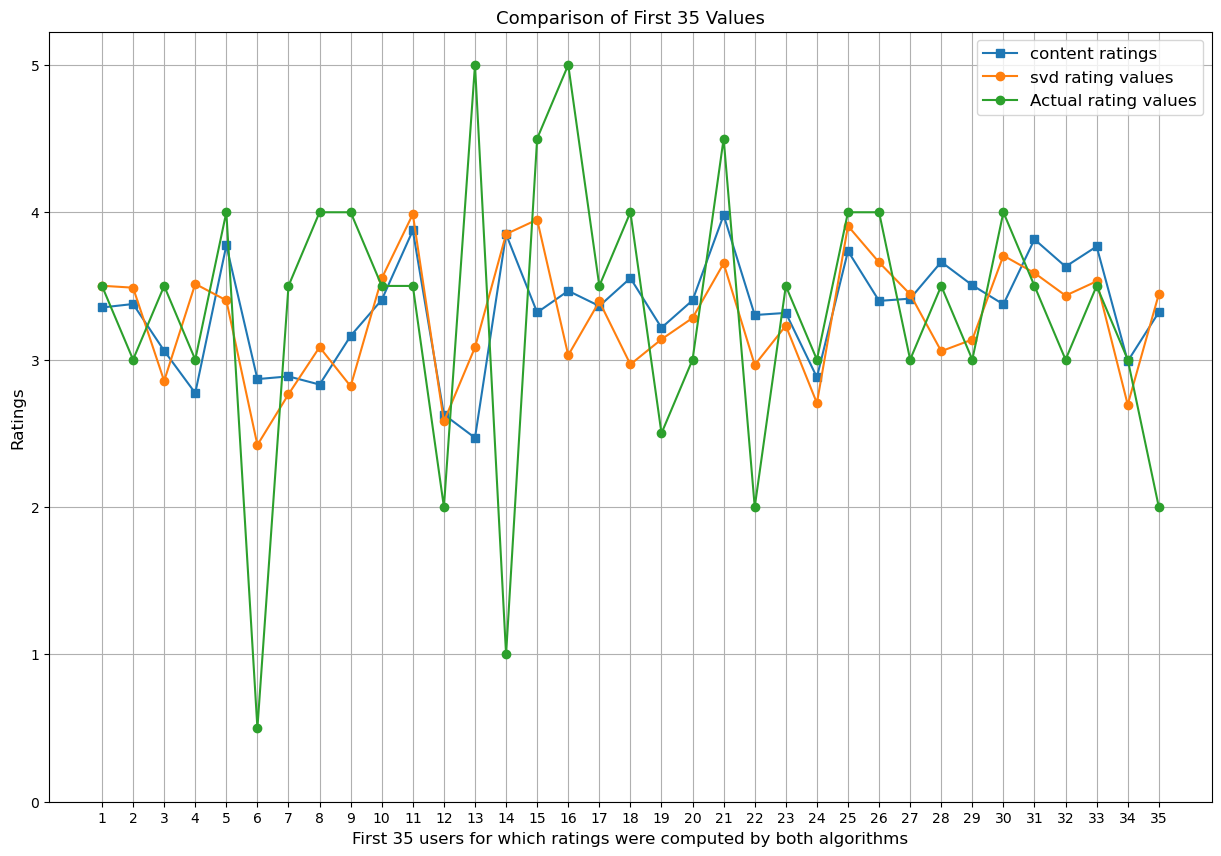

In [12]:
import matplotlib.pyplot as plt

svd_ratings = testDataWithPredictions['svd_pred_rating'].head(35)  
actual_ratings = content_testdf['rating'].head(35)
content_ratings = content_testdf['content_pred_rating'].head(35)  

x_values = range(1, 36)

plt.figure(figsize=(15, 10))
plt.plot(x_values, content_ratings, label='content ratings', marker='s')
plt.plot(x_values, svd_ratings, label='svd rating values', marker='o')
plt.plot(x_values, actual_ratings, label='Actual rating values', marker='o')

plt.title('Comparison of First 35 Values', fontsize=13)
plt.xlabel('First 35 users for which ratings were computed by both algorithms', fontsize=12)
plt.ylabel('Ratings', fontsize=12)

plt.legend(fontsize=12)
plt.xticks(ticks=range(1, 36))  
plt.yticks(ticks=range(0, 6))  

plt.grid(True)
plt.show()


From this graph, we can see that SVD is also an important algorithm to use for reccomendation here. The orange line represents SVD predicted ratings. It can be seen that for several user points, the orange points are closer to the actual rating than the blue points (content-based predicted ratings). This shows that for certain user-movie similarities that the SVD algorithm observes, it is able to determine more accurate ratings for them. Through this graph, we can see why SVD is also an important component of my recommendation algorithm.

Moreover, the SVD RMSE values are better than the content-based RMSE values: 0.8717 < 0.9131. The same applies for both their MAE values, svd MAE < content-based MAE. 

**Now this is where the Hybrid model for recommendations comes. I will combine the SVD and Content-based models to create weighted system that makes as accurate predictions as possible.**
 
*Step by step through the code in this cell*: 

- First I create a new dataframe that specifically stores the userId, movieId, and the svd predicted rating that was calculated in the previous cell using the SVD algorithm
- Then, I also create a new dataframe called content_predicted_df that only contains the userId, movieId, and the content-based prediction ratings that we calculated above with the content-based recommendation approach (using genres). 
- After creating these two dataframes, I create a third dataframe through which I will be experimenting with the hybrid model. I create a dataframe called hybrid_df that merges the svd_predicting_df dataframe and the content_predicting_df dataframe on their common columns, userId and movieId. 
- I also merge hybrid_df with the testing_datas (20% testing dataframe data), specifically with userId, movieId, and rating (which is the actual ratings that the predicted ratings will be compared to). The purpose of doing this is to clearly understand what the dataframe, predicted ratings, and accuracy. 


In [13]:
#pull userid, movieid, and predicted ratings from this dataframe
svd_predicting_df = testDataWithPredictions[['userId', 'movieId', 'svd_pred_rating']]
content_predicting_df = content_testdf[['userId', 'movieId', 'content_pred_rating']]
hybrid_df = svd_predicting_df.merge(content_predicting_df, on=['userId', 'movieId'])
hybrid_df = hybrid_df.merge(
    test_datas[['userId', 'movieId', 'rating']],
    on=['userId', 'movieId'],
    how='left'
)

**Now, here is where I test for different alpha values (changing up which system, SVD or content-based, weighs more in the predicted rating calculations) to determine the weight of each system towards predicted ratings in the testing dataframe.**

*Step by step through code*:

- First, I define a function called predict_with_hybridModel that traverses through each row of the hybrid_df fataframe and computes the weighted predicted rating with a specific alpha value. In this case, I set alpha to 0.75. The "row" essentially refers to the userId. The function calls on that userId's predicted svd rating and predicted content rating to compute the new weighted prediction value. 
- The, I compute the rmse and mae values of the new "hybrid_pred" column which stores the weighted prediction ratings for each user. 

Hybrid Model RMSE Value: 0.8635
Hybrid Model MAE Value: 0.6649
    userId  movieId  svd_pred_rating  content_pred_rating  rating  hybrid_pred
0      590    72998         3.501190             3.353756     3.5     3.464331
1      555     2021         3.488134             3.377327     3.0     3.460432
2      600     1088         2.855145             3.060093     3.5     2.906382
3      217     2150         3.513869             2.773046     3.0     3.328663
4      182     3272         3.402074             3.775003     4.0     3.495307
5      608      158         2.420672             2.867825     0.5     2.532460
6      416     1296         2.764956             2.886216     3.5     2.795271
7      608     4018         3.084717             2.830719     4.0     3.021217
8      509      344         2.819003             3.161007     4.0     2.904504
9      561   109374         3.551486             3.405457     3.5     3.514978
10     551      110         3.987045             3.876409     3.5   

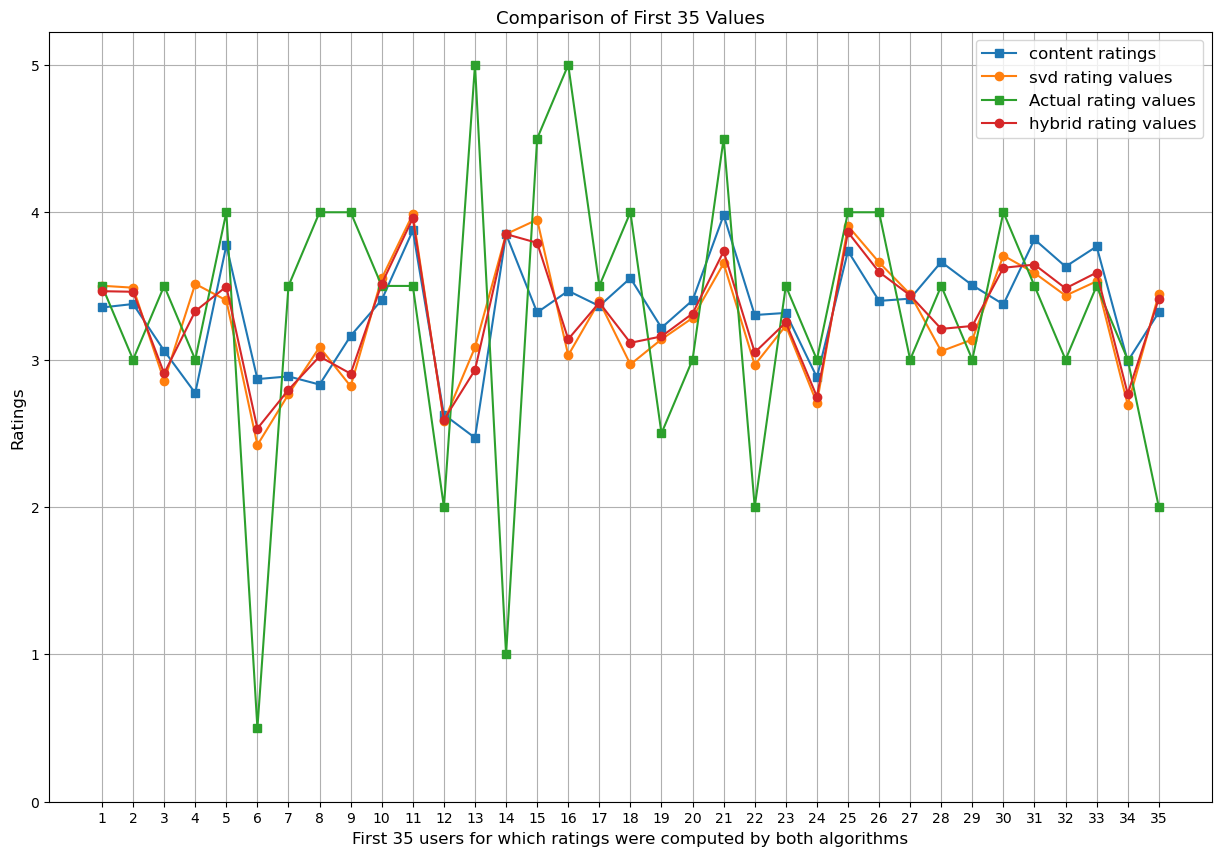

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
def predict_with_hybridModel(row, alpha):
    return alpha * row['svd_pred_rating'] + (1 - alpha) * row['content_pred_rating']

alpha = 0.75
hybrid_df['hybrid_pred'] = hybrid_df.apply(lambda row: predict_with_hybridModel(row, alpha), axis=1)


rmse = np.sqrt(mean_squared_error(hybrid_df['rating'], hybrid_df['hybrid_pred']))
mae = mean_absolute_error(hybrid_df['rating'], hybrid_df['hybrid_pred'])
print(f"Hybrid Model RMSE Value: {rmse:.4f}")
print(f"Hybrid Model MAE Value: {mae:.4f}")
print(hybrid_df.head(35))

hybrid_df.head()
import matplotlib.pyplot as plt
svd_ratings = hybrid_df['svd_pred_rating'].head(35)  
actual_ratings = content_testdf['rating'].head(35)
content_ratings = content_testdf['content_pred_rating'].head(35)  
hybrid_ratings = hybrid_df['hybrid_pred'].head(35)

x_values = range(1, 36)

plt.figure(figsize=(15, 10))
plt.plot(x_values, content_ratings, label='content ratings', marker='s')
plt.plot(x_values, svd_ratings, label='svd rating values', marker='o')
plt.plot(x_values, actual_ratings, label='Actual rating values', marker='s')
plt.plot(x_values, hybrid_ratings, label='hybrid rating values', marker='o')

plt.title('Comparison of First 35 Values', fontsize=13)
plt.xlabel('First 35 users for which ratings were computed by both algorithms', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.legend(fontsize=12)
plt.xticks(ticks=range(1, 36))  
plt.yticks(ticks=range(0, 6))  

plt.grid(True)
plt.show()

**I plotted the individual predicted ratings for the first 35 users in the testing dataframe based on the content-based recommendation system, the SVD algorithm, and the hybrid algorithm. I plotted these three values along with the actual ratings to see how close each model is to the actual rating.**
The graph is above. 


**How I chose the right alpha value**

- I compared the RMSE and MAE values for the hybrid model predictions and plotted them ___ to see which alpha value yielded the lowest RMSE and MAE values. This would help me determine the correct weightage for both recommendation algorithms within the complete hybrid model. 



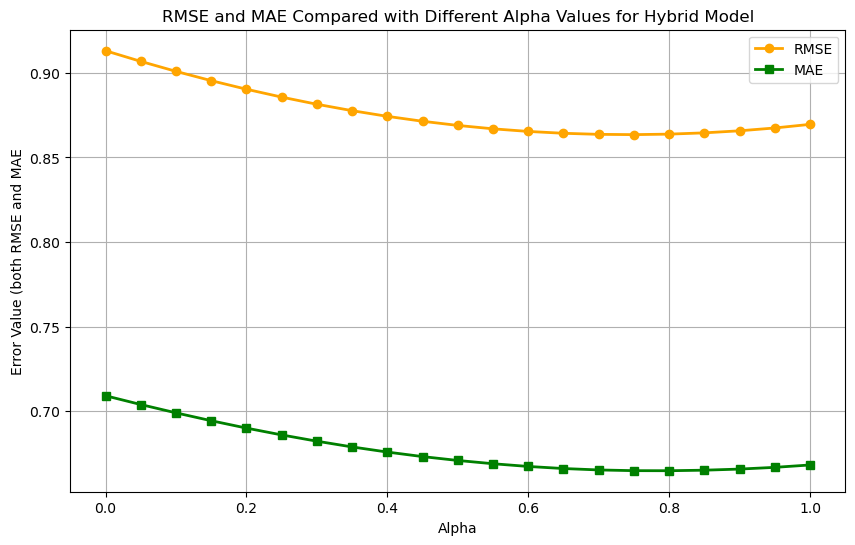

The best alpha value for the weighted hybrid system is: 0.75
Best MAE value: 0.6648
Best RMSE value: 0.8635


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

alpha_values = np.arange(0.0, 1.05, 0.05)  
rmse_values = []
mae_values = []
for alpha in alpha_values:
    hybrid_df['hybrid_pred'] = hybrid_df.apply(lambda row: predict_with_hybridModel(row, alpha), axis=1)
    rmse = np.sqrt(mean_squared_error(hybrid_df['rating'], hybrid_df['hybrid_pred']))
    mae = mean_absolute_error(hybrid_df['rating'], hybrid_df['hybrid_pred'])
    rmse_values.append(rmse)
    mae_values.append(mae)


plt.figure(figsize=(10, 6))
plt.plot(alpha_values, rmse_values, label="RMSE", marker='o', color='orange', linewidth=2)
plt.plot(alpha_values, mae_values, label="MAE", marker='s', color='green', linewidth=2)

plt.title('RMSE and MAE Compared with Different Alpha Values for Hybrid Model')
plt.xlabel('Alpha')
plt.ylabel('Error Value (both RMSE and MAE')
plt.legend()
plt.grid(True)
plt.show()

most_efficient_alpha = alpha_values[np.argmin(rmse_values)]  
print(f"The best alpha value for the weighted hybrid system is: {most_efficient_alpha:.2f}")
print(f"Best MAE value: {min(mae_values):.4f}")
print(f"Best RMSE value: {min(rmse_values):.4f}")



**As can be seen here, the best alpha value for the system is 0.75. The resulting mae and rmse values are appropriately, 0.6658 and 0.8655. Both these numbers are good for a recommendation system.**

**Recommending Top 10 Movies to users that they have not already watched from the testing dataframe**

*Step-by-step through code:*

- My first step is to keep note of all the movie id's that are in the testing dataframe (which we defined at the beginning of this project - content_testdf). 
- Then, I create a list called recommendationList where the top 10 movie recs for the user will be stored. 
- I traverse through all the given userid in the testing dataframe to check find the movies that the user already rated in the training dataframe, and store it in the already_rated_movies set. These movies will not be considered when determining top 10 movie recs. 
- I also determine the set of movies that are not yet rated by calculating the difference between all the movies in the testing dataframe and all the movies that the user already rated. Hence, all the movies that are not yet rated by the user are stored in the set not_yet_rated_movies.
- Then I create a dataframe for the movies that are not rated, called moviesNotRated with the user_id and the movie_id, and their appropriate not_yet_rated movies ids. 
- I merge this dataframe, moviesNotRated, with the hybrid_df dataframe (specifically userid, movieid, and hybrid_pred columns of the hybrid_df) to add the hybrid model predictions for the appropriate user and movie ids already in the moviesNotRated dataframe. 
- Now, I sort the moviesNotRated dataframe in descending order based on hybrid_prediction using the sort_values function.
- I then store the top 10 movie recommendations for the user in "top_ten_recs" which is the first ten elements of the user's moviesNotRated dataframe. 
- Lastly, I set recommendationList equal to specifically the top 10 movie id's in the top_ten_recs (because top_ten_recs consists of the first 10 rows meaning all elements not just movie id). 
- In order to retrive the top ten movie recommendations for a specific user, the last two lines of this cell allow you to pick a userId, and print the top ten recommenations for the user that has that userId. 



    

In [16]:
movieId_in_testingData = set(content_testdf['movieId'])
recommendationList = {}
for user_id in content_testdf['userId'].unique():
    already_rated_movies = set(content_traindf[content_traindf['userId'] == user_id]['movieId'])
    not_yet_rated_movies = movieId_in_testingData - already_rated_movies
    moviesNotRated = pd.DataFrame({'userId': user_id, 'movieId': list(not_yet_rated_movies)})
    moviesNotRated = moviesNotRated.merge(hybrid_df[['userId', 'movieId', 'hybrid_pred']], on=['userId', 'movieId'], how='left')
    moviesNotRated = moviesNotRated.sort_values(by='hybrid_pred', ascending=False)
    
    top_ten_recs = moviesNotRated.head(10)
    
    recommendationList[user_id] = top_ten_recs['movieId'].tolist()
user_id_for_top_ten_rec = 19
print(f"Here the top ten movie recommendations for the following user: {user_id_for_top_ten_rec}: {recommendationList[user_id_for_top_ten_rec]}")


Here the top ten movie recommendations for the following user: 19: [2571, 541, 1197, 1732, 1291, 2804, 1278, 913, 910, 1663]


In [17]:
def explainability(hybrid_df, userId, movieId, movies_df):
    
    svd_prediction = hybrid_df[(hybrid_df['userId'] == 19) & (hybrid_df['movieId'] == 2571)]['svd_pred_rating'].values[0]
    content_prediction = hybrid_df[(hybrid_df['userId'] == 19) & (hybrid_df['movieId'] == 2571)]['content_pred_rating'].values[0]
    alpha = 0.75
    weighted_svd = alpha * svd_prediction
    weighted_content = (1 - alpha) * content_prediction
    movieName = movies_df[movies_df['movieId'] == movieId]['title'].values[0]
    genres = movies_df[movies_df['movieId'] == movieId]['genres'].values[0]

    print(f"Movie: {movieName}")
    print(f"Genres: {genres}")
    print(f"SVD contribution: {weighted_svd}")
    print(f"Content-based contribution: {weighted_content}")
    print(f"Total hybrid rating based on contributions: {weighted_svd+weighted_content}")


transparentValues = explainability(hybrid_df, 19, 1732, movies_df)


Movie: Big Lebowski, The
Genres: Comedy|Crime
SVD contribution: 2.8288208644685326
Content-based contribution: 0.6471550211759163
Total hybrid rating based on contributions: 3.475975885644449


**Above is Optional Task #1**

It provides Transparency and Explainability of Recommender Systems by clearly showing the user how much of the hybrid prediction was contributed to by SVD and content-based filtering, as well as the actual name of the movie recommended and the genres it qualifies under. In order to use this function, the user can generate top ten ratings according to a user_id inputted in the previous cell and then use those same user and movie ids in the above cell to get details about the movie and its rating. 

**The next five cells contain methods to calculate the precision, recall, f-measure, and NDCG to evaluate my recommendations accuracy for the users**

In [18]:
#calculating precision value
def precision_Value(recs, test_dataframe):
    count = 0
    found = 0
    for userid, recMovies in recs.items():
        actual_ratings = set(test_dataframe[test_dataframe['userId'] == userid]['movieId'])
        found = found + len(actual_ratings & set(recMovies))
        count = count + 10
    return found / count
precision = precision_Value(recommendationList, content_testdf)
print(f"Precision Value: {precision:.4f}")

Precision Value: 0.8543


In [19]:
#calcuating recall value
def recallValue(recList, test_dataframe):
    recallVals = []
    k = 10
    for userId, recMovies in recList.items():
        top_ten_movies = set(recMovies[:k])
        movieRated = set(test_dataframe[test_dataframe['userId'] == userId]['movieId'])
        movs = movieRated.intersection(top_ten_movies)
        if len(movieRated) > 0:  
            recallV = len(movs) / len(movieRated)
        else:
            recallV = 0  
        recallVals.append(recallV)
    avgRecallAllUsers = sum(recallVals) / len(recallVals)
    return avgRecallAllUsers
recall = recallValue(recommendationList, content_testdf)
print(f"Recall Value: {recall:.4f}")

Recall Value: 0.6396


In [20]:
precision = precision_Value(recommendationList, content_testdf)
recall_val = recallValue(recommendationList, content_testdf)


def f_measure_value(precision, recall):
    numerator = 2 * precision * recall
    denom = precision+recall
    
    f = numerator/denom
    return f

f_value = f_measure_value(precision, recall_val)

print(f"f-measure value is: {f_value:.4f}")

f-measure value is: 0.7315


In [21]:
#Calculate ndcg for specified user. 
def dcg(rel_vals):
    k = 10
    dcg_value = 0
    for i in range(min(k, len(rel_vals))):  
        dcg_value += rel_vals[i] / np.log2(i + 2) 
    return dcg_value

def ndcg(actual_ratings, predicted_ratings):
    predicted_ratings_sorted = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)
    k=10
    predicted_ratings_relevant = [actual_ratings.get(movie_id, 0) for movie_id, _ in predicted_ratings_sorted[:k]]
    dcgVal = dcg(predicted_ratings_relevant)
    IDCGval = sorted(actual_ratings.items(), key=lambda x: x[1], reverse=True)
    all_IDCG_vals = [ratings for _, ratings in IDCGval[:k]]
    idcg = dcg(all_IDCG_vals)
    return 0 if idcg == 0 else dcgVal / idcg

userId = 19
actual_ratings = dict(zip(content_testdf[content_testdf['userId'] == userId]['movieId'],content_testdf[content_testdf['userId'] == userId]['rating']))
hybrid_pred_ratings = hybrid_df[hybrid_df['userId'] == userId][['movieId', 'hybrid_pred']].values
ndcf_val = ndcg(actual_ratings,hybrid_pred_ratings)
print(f'NDCG value for this user {userId}: {ndcf_val}')


NDCG value for this user 19: 0.8159447701163755


In [22]:
#calculate ndcg for all users:
ndcg_values = []
for userId in content_testdf['userId'].unique():
    pred_ratings = hybrid_df[hybrid_df['userId'] == userId][['movieId', 'hybrid_pred']].values.tolist()
    actual_ratings = dict(zip(content_testdf[content_testdf['userId'] == userId]['movieId'], content_testdf[content_testdf['userId'] == userId]['rating']))
    ndcg_val = ndcg(actual_ratings, pred_ratings)
    ndcg_values.append(ndcg_val)
avd_ndcg_values_all_users = np.mean(ndcg_values)
print(f'Avg NDCG for all the user: {avd_ndcg_values_all_users:.4f}')


Avg NDCG for all the user: 0.9075


**In Summary:**

- The algorithm used: Weighted Hybrid system using SVD and Content-based recommendation (filtering by genre). Alpha value for weight equals 0.75
- Only Content-based: RMSE: 0.9131 
- Only Content-based: MAE: 0.7092
- Only SVD - RMSE: 0.8717 
- Only SVD - MAE:  0.6692
- Hybrid Model RMSE Value: 0.8655
- Hybrid Model MAE Value: 0.6658
- Precision Value: 0.8543
- F-value: 0.7315
- Recall value: 0.6396
- NDCG for all users: 0.9107

Based on these numbers, it can be concluded that the performance of my algorithm is good and mostly/near accurate for the users. The hybrid model has a better RMSE and MAE value than both only SVD and only content-based. Hence, my hybrid algorithm employs methods that were selected and combined using the strengths of both to reach nearly accurate predicted ratings and relevant recommendations.



**Optional Tasks**
Task 1: Transparency and Explainability of Recommender Systems - Completed Above
